# ScispaCy NLP

Russ Steil and Devin Duran

## Intro

ScispaCy is a Python library and extension of the popular spaCy library specifically designed for natural language processing (NLP) tasks in the domain of biomedical and scientific text. It provides pre-trained models and resources for specifically processing and analyzing scientific and biomedical text data.

In this project a pretrained scispaCy Name Entity Recognition model is used to iterate through the 'descriptions' feature of the 32 gigabyte Healthcare Cost dataset found on Kaggle at this link: https://www.kaggle.com/datasets/jpmiller/healthcare and extract the names of any diseases present. The 'descriptions' feature has over 4 million unique values so reducing this number is essential to make the dataset usable for subsequent machine learning. This project epitomizes novelty by working toward a solution for a practical, real-world problem.

The specific NER model used is named 'en_ner_bc5cdr_md' and is trained on the BC5CDR medical corpus which is a collection of 1500 PubMed articles with annotated chemical and annotated disease names.

Although after removal of all NA values in the dataset 294,884,116 rows remain, this project utilizes only 10,000 of these rows due to time constraints. The conclusion of the project features a time complexity analysis of the functions used to iterate through the data.

## Importing

The code below installs scispacy, spacy, and the specific en_ner_bc5cdr_md model. It also imports all of the packages needed and mounts the google drive.

In [23]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_ner_bc5cdr_md-0.5.3.tar.gz
#!pip install scispacy
#!pip install spacy

In [5]:
from google.colab import drive
import pandas as pd
import numpy as np

import scispacy
import spacy

import os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time

import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


This imports 10,000 rows of the description column of the overall healthcare price dataset and stores it both in a pandas dataframe and a numpy array.

It also imports a small dataset that was collected by running the function on various input sizes and measuring the runtime.

In [9]:
column_types = {'description':'string'}
use_cols = ['description']

file_path = '/content/drive/My Drive/Colab Notebooks/Classification/description_untokenized.csv'
pandas_df = pd.read_csv(file_path, dtype=column_types, usecols = use_cols, nrows = 10000)

numpy_array = pandas_df['description'].to_numpy()
type(numpy_array)

file_path = '/content/drive/My Drive/Colab Notebooks/Classification/tokenizer_time.csv'
time_df = pd.read_csv(file_path, index_col=False)

## Data Processing

### NLP model application

This code initializes the NLP model as sci_nlp and prints its labels: 'CHEMICAL' and 'DISEASE'. For our purposes only 'DISEASE' is used.

In [10]:
sci_nlp = spacy.load('en_ner_bc5cdr_md')
print(sci_nlp.component_names)
print(sci_nlp.get_pipe('ner').labels)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']
('CHEMICAL', 'DISEASE')


This function iterates through a string and returns the diseases within that string labeled by the scispacy NLP.


In [11]:
def extract_diseases(text):
  docx = sci_nlp(text)
  return [ent.text for ent in docx.ents if ent.label_ == 'DISEASE']

In [12]:
%%time
disease_tokens = pandas_df['description'].apply(lambda x:extract_diseases(x))


CPU times: user 1min 36s, sys: 101 ms, total: 1min 36s
Wall time: 1min 36s


When applied to the description column of the pandas dataframe it extracts the disease name 'seizures' from the first 5 rows. However, the runtime of 1min 36s can be greatly reduced using parallel processing on numpy arrays.

In [13]:
print(disease_tokens.head(5))

0    [seizures]
1    [seizures]
2    [seizures]
3    [seizures]
4    [seizures]
Name: description, dtype: object


### NLP model optimization

The code below counts the number of CPU cores available and distributes the workload amongst all of them to iterate through the numpy array version of the descriptions at a quicker pace.

In [14]:
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cpu_cores}")

def process_text_parallel(text_array):
    with Pool(num_cpu_cores) as pool:
        return pool.map(extract_diseases, text_array)

Number of CPU cores available: 8


In [15]:
%%time
start_time = time.time()

disease_tokens = process_text_parallel(numpy_array)

end_time = time.time()

CPU times: user 321 ms, sys: 493 ms, total: 813 ms
Wall time: 20.2 s


This code accomplished the exact same task at roughly 5x the pace.



In [22]:
size = len(numpy_array)

### Further cleaning and Export

The NLP model returns the diseases extracted from the description as a list, but the lists are empty for the descriptions that do not contain the names of any diseases. These rows can be removed since they are not able to be relevantly labeled.

In [17]:
pandas_df['disease_token'] = disease_tokens
pandas_df.tail(10)

,description,disease_token
9990,tube suction kamvac mini curve sterile latex free,[]
9991,tube suction kamvac mini curve sterile latex free,[]
9992,knife ophthalmic 3.2mm a-ok satinslit 45d full...,[]
9993,knife ophthalmic 3.2mm a-ok satinslit 45d full...,[]
9994,knife ophthalmic 1.4mm 20ga a-ok v-lance strai...,[]
9995,knife ophthalmic 1.4mm 20ga a-ok v-lance strai...,[]
9996,knife ophthalmic blue 2.9mm ultrasharp griesha...,[]
9997,knife ophthalmic blue 2.9mm ultrasharp griesha...,[]
9998,probe hemostatic eraser 45d 18ga bipolar hollo...,[]
9999,probe hemostatic eraser 45d 18ga bipolar hollo...,[]


Doing this reduces the size of the dataframe by a factor of 10. This is crucial to decreasing the size of the overall dataset since 29 million rows is a lot easier to deal with than 290 million.

In [18]:
pandas_df = pandas_df[pandas_df['disease_token'].apply(lambda x: len(x) > 0)]

print(len(pandas_df))
pandas_df.tail(5)

966


,description,disease_token
9891,passer surgical 55cm uni-shunt long peritoneum...,[hydrocephalus]
9930,set drainage 29cm 9fr 18ga stainless steel tfe...,[pneumothorax]
9931,set drainage 29cm 9fr 18ga stainless steel tfe...,[pneumothorax]
9940,packing nasal merocel l10 cm x w1.5 cm x h2.5 ...,[white epistaxis]
9941,packing nasal merocel l10 cm x w1.5 cm x h2.5 ...,[white epistaxis]


This code updates the time dataframe with the time data obtained from this iteration (input size 10,000 and runtime of 20.2s) and also exports the pandas dataframe with the disease tokens row.

The 'description' column remains even though its data is now irrelevant because it will serve as the foreign key to inner join the 'disease_token' column with the original dataset.

In [19]:
elapsed_time = end_time - start_time
size = len(numpy_array)

time_df = time_df.append({'Input Size':size, 'Time':elapsed_time}, ignore_index=True)
time_df = time_df.sort_values(by='Input Size', ascending=True)

time_df.to_csv('/content/drive/My Drive/Colab Notebooks/Classification/tokenizer_time.csv', index=False)
pandas_df.to_csv('/content/drive/My Drive/Colab Notebooks/Classification/description_tokenized.csv', index=False)

<ipython-input-19-ecbadd993428>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_df = time_df.append({'Input Size':size, 'Time':elapsed_time}, ignore_index=True)


## Time Complexity Analysis

This code creates a graph of the runtime data collected at different input sizes for the NLP model and a linear regression prediction model based on this data that is used to predict the runtime for the entire dataset.

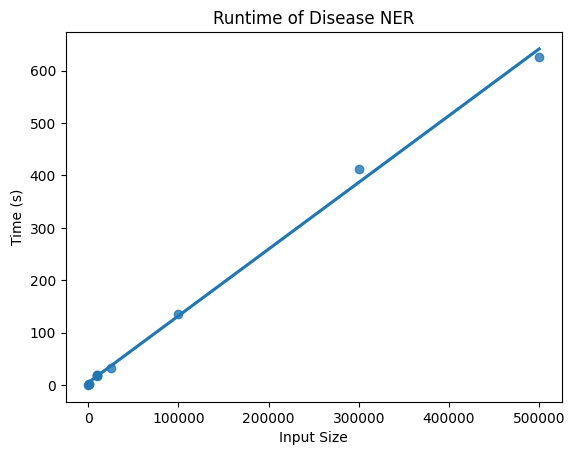

In [20]:
x = time_df['Input Size']
y = time_df['Time']

sns.regplot(x=x, y=y, data=time_df, ci=None)

plt.xlabel('Input Size')
plt.ylabel('Time (s)')
plt.title('Runtime of Disease NER')

plt.show()

In [21]:
n = len(x)
m = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (n * np.sum(x**2) - (np.sum(x)**2))
b = (np.sum(y) - m * np.sum(x)) / n

input_size_predict = 294884116
predicted_time = m * input_size_predict + b

print(f"Input Size: {input_size_predict}")
print(f"Predicted Time: {predicted_time:.0f} seconds, {predicted_time/3600:.2f} hours, or {predicted_time/86400:.2f} days")

Input Size: 294884116
Predicted Time: 375420 seconds, 104.28 hours, or 4.35 days


So this presents us with good news and bad news. The good news: the function runs at an O(n) runtime, which is pretty fast. The bad news: in order to process the 294,884,116 rows it would take around 4.35 days according to our linear regression model.

## Conclusion


Ultimately, the BC5CDR NER model was able to extract the disease names from the 'description' column. However, in order to effectively extract and clean the disease names for the entire dataset there are only three options: try to optimize the code further, find a stronger computer to run the code on, or find a way to consistently run the program for 4.35 days.

I feel that it will require a combination of these to successfully complete this task, considering that to optimize the code to a comfortable time (around 1 hour) it would have to become 104x faster (predicted 104 hour runtime currently).

However, once this bottleneck is resovled and the new 'description_tokens' column is inner joined on the healthcare dataset I estimate there will be less than 29 million rows and the dataset will be smaller than 3.3 gigabytes instead of 33. This is much more workable and then a neural net or simpler machine learning algorithms can be used to derive important healthcare cost data.